# Novel Anomaly Detection Method: Combined Autoencoder and  Benford's First Digit Analysis

## For Accounting Journal Entry Data Anomaly Detection

## Project Participants
| Student ID     | Name                     | University                         | Department |
|----------------|--------------------------|------------------------------------|------------|
| 12030121120034 | Muhammad Dzaki Al Aqsha  | Universitas Diponegoro             | Accounting |

## Project Overview
This project was developed as part of an **undergraduate thesis (skripsi)** to fulfill the graduation requirements for a bachelor's degree. The research aims to develop and introduce a novel anomaly detection procedure on accounting journal entry data by combining autoencoder and Benford's first digit analysis.This project is greatly inspired by the [work](https://github.com/GitiHubi/deepAI) of Marco Schreyer and Timur Sattarov.

## 1. Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MeanSquaredError, Reduction
from tensorflow.data import Dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import leaky_relu

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from functools import partial
from re import X

In [2]:
repo_url = "https://github.com/dzakialaqsha/autoencoder-benford-analysis.git"
!git clone {repo_url}

Cloning into 'autoencoder-benford-analysis'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 158 (delta 77), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (158/158), 14.49 MiB | 4.68 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [3]:
%cd "/content/autoencoder-benford-analysis/utils"
import data_preprocessing
import model_building
import benford_analysis

/content/autoencoder-benford-analysis/utils


## 2. Import the Data

### 2.1. Original Data

In [4]:
fraud_data = pd.read_csv("/content/autoencoder-benford-analysis/data/fraud_dataset_v1.csv")
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533009 entries, 0 to 533008
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   WAERS   533009 non-null  object 
 1   BUKRS   533009 non-null  object 
 2   KTOSL   533009 non-null  object 
 3   BELNR   533009 non-null  object 
 4   BSCHL   533009 non-null  object 
 5   HKONT   533009 non-null  object 
 6   DMBTR   533009 non-null  float64
 7   WRBTR   533009 non-null  float64
 8   label   533009 non-null  object 
dtypes: float64(2), object(7)
memory usage: 36.6+ MB


### Fraud Data Variables Explanation
| Index | Original Name | Description |
|---|---|---|
| 0 | WAERS | Currency Key, which specifies the currency in which amounts are entered. |
| 1 | BUKRS | Company Code, which identifies a company or a legal entity. |
| 2 | KTOSL | Transaction Key, which controls the posting of line items. |
| 3 | BELNR | Document Number, which uniquely identifies an accounting document. |
| 4 | BSCHL | Posting Key, which determines how a line item is posted to an account. |
| 5 | HKONT | GL Account Number, which is a key to a general ledger account. |
| 6 | DMBTR | Amount in Local Currency, representing the value of a transaction. |
| 7 | WRBTR | Amount in Foreign Currency, representing the transaction value in its original currency. |

In [5]:
fraud_data.head(15)

,WAERS,BUKRS,KTOSL,BELNR,BSCHL,HKONT,DMBTR,WRBTR,label
0,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


### 2.2. Sampling the Data

In [6]:
sampled_fraud_data = data_preprocessing.benford_distribution_preserving_sampling(fraud_data, 'HKONT', 'DMBTR', 100000)
sampled_fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100042 entries, 0 to 100041
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   WAERS   100042 non-null  object 
 1   BUKRS   100042 non-null  object 
 2   KTOSL   100042 non-null  object 
 3   BELNR   100042 non-null  object 
 4   BSCHL   100042 non-null  object 
 5   HKONT   100042 non-null  object 
 6   DMBTR   100042 non-null  float64
 7   WRBTR   100042 non-null  float64
 8   label   100042 non-null  object 
dtypes: float64(2), object(7)
memory usage: 6.9+ MB


In [7]:
sampled_fraud_data = pd.concat([sampled_fraud_data, fraud_data[fraud_data.label == "global"], fraud_data[fraud_data.label == "local"]], axis='rows')
old_data = sampled_fraud_data.copy()
sampled_fraud_data.value_counts('label')

,count
label,
regular,99968
global,140
local,34


## 3. Data Preprocessing

In [8]:
sampled_fraud_data = sampled_fraud_data.drop(['label'], axis='columns')
np_sampled_fraud_data = data_preprocessing.data_preprocessing(sampled_fraud_data, ['WAERS', 'BUKRS', 'KTOSL', 'BELNR', 'BSCHL', 'HKONT'], ['DMBTR', 'WRBTR'])
np_sampled_fraud_data

array([[9.99999672e-01, 9.99999815e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.18018667e-02, 1.18066500e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.98130551e-03, 1.70193656e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.85066169e-03, 9.13532957e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.85084708e-03, 9.13681232e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.85056499e-03, 9.13810929e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## 4. Initial Autoencoder Deployment

### 4.1. Initialize the Model

In [9]:
autoencoder_model = model_building.build_autoencoder(input_dim=np_sampled_fraud_data.shape[1], latent_dim=2)
autoencoder_model.summary()

Model: "Functional_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 618)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       158,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_4 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_5 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_6 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_7 (Dense)               │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Latent_Space (Dense)            │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_3 (Dense)               │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_4 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_5 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_6 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_7 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Reconstruction_Output (Dense)   │ (None, 618)            │       158,826 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,428 (1.55 MB)

 Trainable params: 405,428 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2. Training the Model

Epoch 1/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.0160
Epoch 2/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0040
Epoch 3/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0038
Epoch 4/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0038
Epoch 5/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0037
Epoch 6/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0033
Epoch 7/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0031
Epoch 8/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0029
Epoch 9/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0028
Epoch 10/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0028
Epoch 11/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0028
Epoch 12/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0027
Epoch 13/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0026
Epoch 14/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0024
Epoch 15/15
313

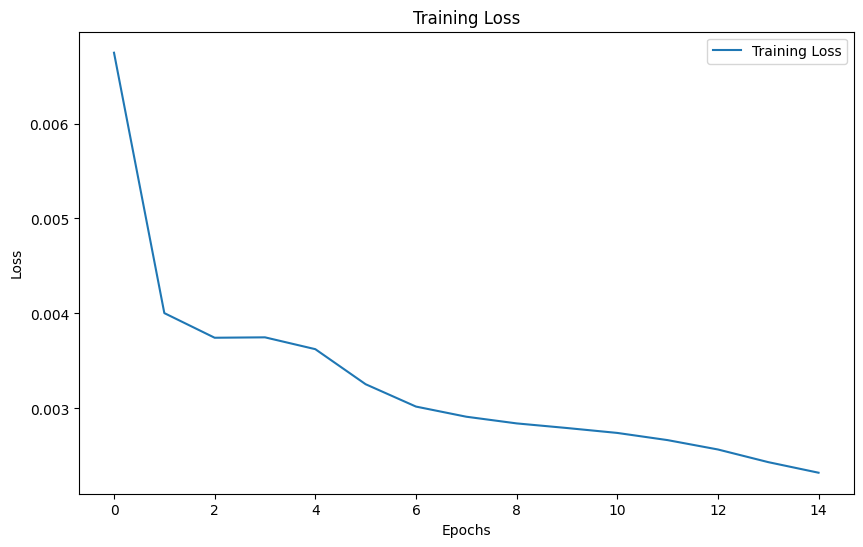

In [10]:
history, reconstructions, individual_mse, fig = model_building.train_autoencoder(autoencoder_model, np_sampled_fraud_data, epochs=15, batch_size=128, learning_rate=0.001)

### 4.3. Save the training outputs

In [11]:
%cd "/content/autoencoder-benford-analysis/"
%mkdir "Saved Training Data"

/content/autoencoder-benford-analysis
mkdir: cannot create directory ‘Saved Training Data’: File exists


In [12]:
pd.DataFrame(history.history).to_csv("/content/autoencoder-benford-analysis/Saved Training Data/history.csv")
np.save('/content/autoencoder-benford-analysis/Saved Training Data/individual_mse.npy', individual_mse)
fig.savefig('/content/autoencoder-benford-analysis/Saved Training Data/training_loss_plot.png')
autoencoder_model.save('/content/autoencoder-benford-analysis/Saved Training Data/autoencoder_model.keras')

In [13]:
old_data['reconstruction_error'] = individual_mse
old_data['label'] = old_data['label'].isin(['global','local']).astype(int)
old_data.head(25)

,WAERS,BUKRS,KTOSL,BELNR,BSCHL,HKONT,DMBTR,WRBTR,label,reconstruction_error
0,J73,K76,Q44,K32,H00,A42,9.244551e+07,5.958505e+07,1,0.010528
1,C9,C90,C1,C18,A2,B1,1.091040e+06,7.035000e+03,0,0.001618
2,C2,C28,C1,C10,A1,B1,1.831726e+05,1.014100e+04,0,0.001577
3,C1,C19,C5,C58,A1,B1,1.154395e+06,0.000000e+00,0,0.002814
4,C7,C70,C1,C15,A3,B1,1.537143e+06,0.000000e+00,0,0.000513
5,C1,C18,C5,C59,A1,B1,1.253433e+06,2.883750e+05,0,0.002151
6,C1,C19,C1,C11,A1,B1,1.398734e+05,0.000000e+00,0,0.003236
7,C2,C20,C1,C19,A1,B1,1.292003e+06,5.962400e+04,0,0.000002
8,C1,C17,C1,C16,A1,B1,1.633361e+05,2.108800e+04,0,0.001618
9,C1,C15,C9,C99,A1,B1,1.090806e+05,0.000000e+00,0,0.002186


$$
\text{desired percentile} = \frac{\text{number of observations} - \text{desired number of observations to be flagged}}{\text{number of observations}} \cdot 100
$$

In [14]:
desired_percentile = float(((old_data.shape[0] - 150) / old_data.shape[0]) * 100)
percentile = float(np.percentile(individual_mse, desired_percentile))
prediction_data = model_building.heaviside_step_function(old_data, individual_mse, percentile)
prediction_data.rename(columns={'predicted_label': 'autoencoder_label'}, inplace=True)
prediction_data.head(15)

,WAERS,BUKRS,KTOSL,BELNR,BSCHL,HKONT,DMBTR,WRBTR,label,reconstruction_error,autoencoder_label
0,J73,K76,Q44,K32,H00,A42,9.244551e+07,5.958505e+07,1,0.010528,1
1,C9,C90,C1,C18,A2,B1,1.091040e+06,7.035000e+03,0,0.001618,0
2,C2,C28,C1,C10,A1,B1,1.831726e+05,1.014100e+04,0,0.001577,0
3,C1,C19,C5,C58,A1,B1,1.154395e+06,0.000000e+00,0,0.002814,0
4,C7,C70,C1,C15,A3,B1,1.537143e+06,0.000000e+00,0,0.000513,0
5,C1,C18,C5,C59,A1,B1,1.253433e+06,2.883750e+05,0,0.002151,0
6,C1,C19,C1,C11,A1,B1,1.398734e+05,0.000000e+00,0,0.003236,0
7,C2,C20,C1,C19,A1,B1,1.292003e+06,5.962400e+04,0,0.000002,0
8,C1,C17,C1,C16,A1,B1,1.633361e+05,2.108800e+04,0,0.001618,0
9,C1,C15,C9,C99,A1,B1,1.090806e+05,0.000000e+00,0,0.002186,0


## 5. Benford's Digit Analysis

In [15]:
prediction_data = benford_analysis.benford_anomaly_detection(dataset=prediction_data, first_digit_column='DMBTR', target_column='HKONT')

## 6. Combined Approach

In [16]:
prediction_data = prediction_data.reset_index(drop=True)
prediction_data['threshold_adjacency_applicability'] = False
prediction_data.loc[prediction_data['reconstruction_error'] < percentile, 'threshold_adjacency_applicability'] = True
prediction_data['threshold_distance'] = 0.0
prediction_data['threshold_adjacency'] = 0.0
prediction_data.loc[prediction_data['threshold_adjacency_applicability'] == True, 'threshold_distance'] = (percentile - prediction_data['reconstruction_error'])
prediction_data.loc[prediction_data['threshold_adjacency_applicability'] == True, 'threshold_adjacency'] = (prediction_data.threshold_distance - prediction_data.threshold_distance.min()) / (prediction_data.threshold_distance.max() - prediction_data.threshold_adjacency.min())
prediction_data.loc[prediction_data['threshold_adjacency_applicability'] == True, 'threshold_adjacency'] = 1 - prediction_data.threshold_adjacency

In [17]:
prediction_data['norm_benford_mad'] = (prediction_data.benford_mad - prediction_data.benford_mad.min())/(prediction_data.benford_mad.max() - prediction_data.benford_mad.min())
prediction_data.loc[prediction_data['norm_benford_mad'] < 1, 'norm_benford_mad'] = prediction_data['norm_benford_mad'] + 1e-9
prediction_data['multiplier'] = (prediction_data['norm_benford_mad'] + prediction_data['threshold_adjacency'] + prediction_data['benford_label'])/3
#danger zone
prediction_data['multiplier'] = prediction_data['multiplier'] + (1/3) #going above and beyond if all three criterias are met, and lift if two criteria is met
# danger zone
prediction_data['new_reconstruction_error'] = prediction_data['reconstruction_error'] + (prediction_data['multiplier'] * prediction_data['threshold_distance'])
prediction_data['new_reconstruction_error'] = prediction_data['new_reconstruction_error'] + 1e-9 #to prevent fence sitting
prediction_data = model_building.heaviside_step_function(prediction_data, prediction_data.new_reconstruction_error.values, percentile)
prediction_data.rename(columns={'predicted_label': 'combined_label'}, inplace=True)

In [18]:
prediction_data.head()

,WAERS,BUKRS,KTOSL,BELNR,BSCHL,HKONT,DMBTR,WRBTR,label,reconstruction_error,...,benford_conformity,benford_mad,benford_label,threshold_adjacency_applicability,threshold_distance,threshold_adjacency,norm_benford_mad,multiplier,new_reconstruction_error,combined_label
0,J73,K76,Q44,K32,H00,A42,9.244551e+07,5.958505e+07,1,0.010528,...,Significant Deviation,0.212054,1,False,0.000000,0.000000,1.000000e+00,1.000000,0.010528,1
1,C9,C90,C1,C18,A2,B1,1.091040e+06,7.035000e+03,0,0.003791,...,Acceptable Conformity,0.005317,0,True,0.005280,0.234602,1.000000e-09,0.411534,0.003791,0
2,C2,C28,C1,C10,A1,B1,1.831726e+05,1.014100e+04,0,0.003756,...,Acceptable Conformity,0.005317,0,True,0.005321,0.228605,1.000000e-09,0.409535,0.003756,0
3,C1,C19,C5,C58,A1,B1,1.154395e+06,0.000000e+00,0,0.004731,...,Acceptable Conformity,0.005317,0,True,0.004084,0.407982,1.000000e-09,0.469327,0.004731,0
4,C7,C70,C1,C15,A3,B1,1.537143e+06,0.000000e+00,0,0.002800,...,Acceptable Conformity,0.005317,0,True,0.006385,0.074376,1.000000e-09,0.358125,0.002800,0


## 7. Combined Approach Evaluation

In [19]:
accuracy, precision, recall, f1, confusion_mat = model_building.evaluate_prediction(prediction_data, 'label', 'combined_label')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9995506380939067
Precision: 0.9271523178807947
Recall: 0.8045977011494253
F1 Score: 0.8615384615384616
